In [194]:
import h5py

images1 = h5py.File('zx_7_d10_inmc_celebA_01.hdf5')['zx_7']
images2 = h5py.File('zx_7_d10_inmc_celebA_02.hdf5')['zx_7']
images3 = h5py.File('zx_7_d10_inmc_celebA_03.hdf5')['zx_7']
images4 = h5py.File('zx_7_d10_inmc_celebA_04.hdf5')['zx_7']
images5 = h5py.File('zx_7_d10_inmc_celebA_05.hdf5')['zx_7']
images6 = h5py.File('zx_7_d10_inmc_celebA_20.hdf5')['zx_7']

lights1 = h5py.File('zx_7_d3_lrgb_celebA_01.hdf5')['zx_7']
lights2 = h5py.File('zx_7_d3_lrgb_celebA_02.hdf5')['zx_7']
lights3 = h5py.File('zx_7_d3_lrgb_celebA_03.hdf5')['zx_7']
lights4 = h5py.File('zx_7_d3_lrgb_celebA_04.hdf5')['zx_7']
lights5 = h5py.File('zx_7_d3_lrgb_celebA_05.hdf5')['zx_7']
lights6 = h5py.File('zx_7_d3_lrgb_celebA_05.hdf5')['zx_7']

In [195]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

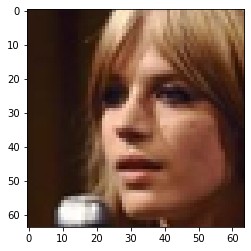

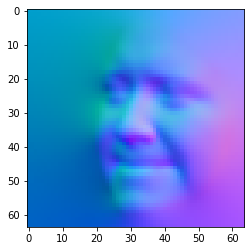

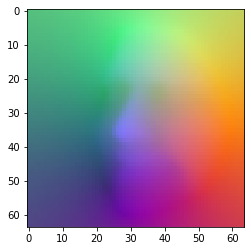

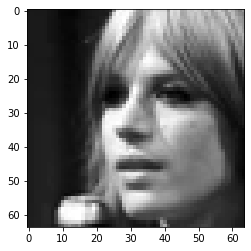

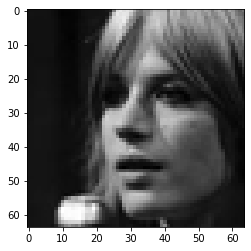

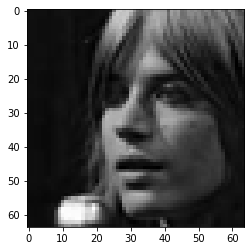

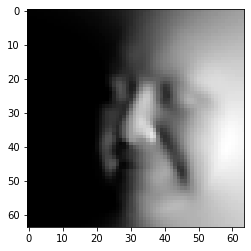

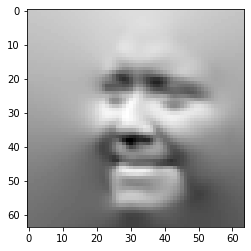

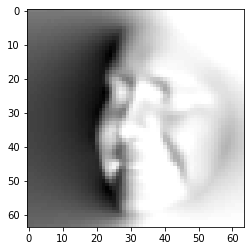

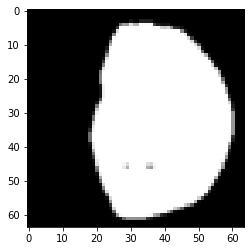

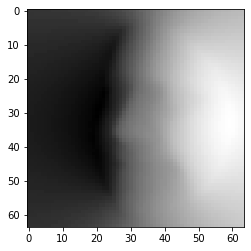

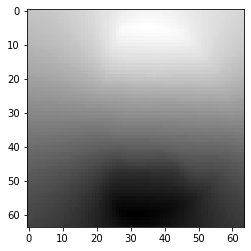

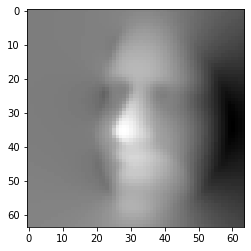

In [196]:
idx = 0

x = images1[idx][0:3]
y = images1[idx][3:6]
z = images1[idx][7:10]
npx = np.array(x)
npy = np.array(y)
npz = np.array(z)
npx = np.transpose(npx, (1, 2, 0))
npy = np.transpose(npy, (1, 2, 0))
npz = np.transpose(npz, (1, 2, 0))
plt.figure()
plt.imshow(npx)
plt.figure()
plt.imshow(npy)
plt.figure()
plt.imshow(npz)

for j in range(10):
    plt.figure()
    plt.imshow(images1[idx][j], cmap='gray')

In [200]:
c1 = 0.429043
c2 = 0.511664
c3 = 0.743125
c4 = 0.886227
c5 = 0.247708

maxResponse = 0

def shading(imagesFile, lightsFile, index):
    global maxResponse
    normals = imagesFile[index][3:6]
    lights = np.array(lightsFile[index])
    npn = np.array(normals)
    npn = np.transpose(npn, (1, 2, 0))
    
    adding = np.ones((64, 64, 1))
    npn = np.concatenate((npn, adding), 2)
    
    shading = np.zeros_like(normals[0])
    
    colorShadings = []
    
    for l in lights:
        K = np.array([[c1 * l[8], c1 * l[4], c1 * l[7], c2 * l[3]],
                      [c1 * l[4], -c1 * l[8], c1 * l[5], c2 * l[1]],
                      [c1 * l[7], c1 * l[5], c3 * l[6], c2 * l[2]],
                      [c2 * l[3], c2 * l[1], c2 * l[2], c4 * l[0] - c5 * l[6]]])
        npnr = np.reshape(npn, (64 * 64, 4))
        colorShading = np.sum(((npnr @ K.T) * npnr), 1)
        colorShading = np.reshape(colorShading, (64, 64))
        colorShading[colorShading < 0] = 0
        shading += colorShading / 3
        
    return shading
        
                
def toLinearSpace(imagesFile, index, show = False):
    image = np.array(imagesFile[index][:3])
    image = np.power(((image + 0.055) / (1.055)), 2.4)
        
    
    if show:
        image = np.transpose(image, (1, 2, 0))
        plt.figure()
        plt.imshow(image)
        
    return image
    

In [199]:
averagePixels = np.zeros((50765, 3))

globalIndex = 0

for imageFile, lightsFile in zip(imageFiles, lightFiles):
    for i in tqdm(range(len(imageFile))):
        image = toLinearSpace(imageFile, i)
        averagePixel = np.sum(np.sum(image, 1) / 64, 1) / 64
        averagePixels[globalIndex] = averagePixel
        globalIndex += 1
        
globalAverage = np.sum(averagePixels, 0) / 50765

100%|██████████| 2533/2533 [00:01<00:00, 1421.35it/s]


In [202]:
with h5py.File("../data/lin_image_shading_mask_all_1.hdf5", "w") as f:
    dset = f.create_dataset('default', (50765, 5, 64, 64))
    
    globalIndex = 0
    
    for imageFile, lightsFile in zip(imageFiles, lightFiles):
        for i in tqdm(range(len(imageFile))):
            image = toLinearSpace(imageFile, i)
            image[0] -= globalAverage[0]
            image[1] -= globalAverage[1]
            image[2] -= globalAverage[2]
            dset[globalIndex,0:3,:,:] = image            
            dset[globalIndex,3,:,:] = shading(imageFile, lightsFile, i)
            dset[globalIndex,4,:,:] = imageFile[i][6]
            
            globalIndex += 1


100%|██████████| 2533/2533 [00:09<00:00, 276.92it/s]


In [203]:
globalAverage

array([0.35064762, 0.21667774, 0.16786481])